# Customer Cancellation Intervention
## Definition
### Project Overview and Problem Statement
For a subscription-based business, reducing customer churn is critical to maintaining high growth. This project will examine a nearly six month slice of subscription transactions from such a business in an attempt to identify patterns leading to cancellation. The goal is to train a classifier capable of identifying customers at risk of cancellation using details of upcoming subscription transactions.

The search for a reasonable predictor will follow this general outline:
1. Data preparation
* Data visualization
* Algorithm selection
* Feature preprocessing
  1. Imputation of missing values
  * Creation of dummy columns for categorical features
* Benchmarking
* Algorithm parameter tuning
* Validation testing

The target column, `ServiceLevelChange`, can be one of `No change`, `Downgraded`, or `Deactivated` and represents the service level change of the kit in the 45 days following the refill. As such, this is a multiclass classification problem. Moreover, as will be explored below, the classes are heavily unbalanced with nearly 98% of the samples belonging to the `No change` class. The choice of performance metric will therefore be critical, as many common metrics perform poorly with unbalanced classes. Finally, due to data integrity issues, purchase information is not available for many kits and will need to be imputed.

**A note on vocabulary:** A customer of this business purchases a **kit** containing several different products. Each of these products are then **refilled** before expiration as part of the subscription service.

### Metrics
Considering that this predictor will be used in an intervention system, it's important to maintain a high precision and minimize false positives. Otherwise, time and money will be spent "intervening" with customers who have no intention of cancelling. Of course, the predictor should catch as many potential cancellations as possible, but the algorithm's performance in this respect can be improved iteratively as customer behavior is better understood. A custom scorer will therefore be used that is the recall score if precision is at least 0.9. Otherwise, the score will be zero.

*See the [Improvement](#Improvement) section of the Conclusion for a potential performance metric based on lifetime customer value.*

## Analysis
### Data Exploration
Data for this project was prepared through a deep-dive of the company's database. After identifying several restrcitions - chief among these being lack of audits on the statuses of kits and data integrity issues for older kits - the following features for each refill were identified, organized into views, and extracted:
1. `RefillNumber`: The ordinality of this transaction in the refill history. For example, `RefillNumber=1` corresponds to a kit's first refill, and the fifth refill will have a `RefillNumber` of `5`.
* `RefillAmount`: The cost of this refill.
* `AdvancedNotified`: Customers with up-to-date contact information are sent an email 2-4 weeks before their refill is scheduled for delivery. This field indicates which refills were preceded by such a notification.
* `KitType`: A kit's type determines the mix of products contained within it.
* `KitPurchasePrice`: The purchase price of the kit.
* `KitDistributionChannel`: The distribution channel through which the customer purchased the kit. One of `DIRECT`, `DEALER`, or `WEB`.
* `CustomerIsCorporate`: Some customers are associate with each other through a larger organization known as a corporation.
* `PreviousRefillsAmount`: The sum of the cost of all previous refills for this kit.
* `DaysSinceLastRefill`: The number of days since the last refill.
* `DaysSinceKitPurchase`: The number of days since the kit was purchased.

After some initial training and testing, two more features were later added:
* `RefillItems`: The number of items in this refill.
* `CustomerState`: The US state to which the customer belongs.

In [1]:
# Import refill data
import numpy as np
import pandas as pd
from IPython.display import display
refill_data = pd.read_csv('refill_data.csv')
category_columns = [
    'AdvancedNotified',
    'KitType',
    'KitDistributionChannel',
    'CustomerIsCorporate',
    'CustomerState',
    'ServiceLevelChange'
]
for column in category_columns:
    refill_data[column] = refill_data[column].astype('object')
display(refill_data.head(3))
display(refill_data.describe())
display(refill_data[category_columns].describe())

,RefillNumber,RefillAmount,RefillItems,AdvancedNotified,KitType,KitPurchasePrice,KitDistributionChannel,CustomerIsCorporate,CustomerState,PreviousRefillsAmount,DaysSinceLastRefill,DaysSinceKitPurchase,ServiceLevelChange
0,19,129.40,3,0,G,NaN,NaN,0,NJ,3689.04,156,3145,No change
1,19,129.40,3,0,G,NaN,NaN,0,CA,3689.04,156,3167,No change
2,1,91.28,7,0,F,NaN,NaN,0,CA,0.00,NaN,3185,No change


,RefillNumber,RefillAmount,RefillItems,KitPurchasePrice,PreviousRefillsAmount,DaysSinceLastRefill,DaysSinceKitPurchase
count,47489.000000,47489.00000,47489.000000,35154.000000,47489.000000,44431.000000,47489.000000
mean,8.759523,223.64987,3.677209,376.467484,1686.721326,119.733497,1914.036303
std,5.656329,164.72680,2.094210,315.602269,1131.503088,105.596982,1809.179766
min,1.000000,29.45000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,75.50000,2.000000,120.800000,705.380000,63.000000,943.000000
50%,8.000000,142.06000,3.000000,333.350000,1691.210000,99.000000,1412.000000
75%,12.000000,322.61000,5.000000,532.100000,2354.540000,154.000000,1945.000000
max,31.000000,1194.06000,33.000000,3144.950000,7272.910000,2872.000000,42464.000000


,AdvancedNotified,KitType,KitDistributionChannel,CustomerIsCorporate,CustomerState,ServiceLevelChange
count,47489,47489,35154,47489,47489,47489
unique,2,20,3,2,57,3
top,0,J,DIRECT,0,CA,No change
freq,25468,22242,27530,41276,8927,46412


In [2]:
# Separate data into features (X) and target (y)
X_raw = refill_data[list(refill_data.columns[:-1])]
y_all = refill_data[refill_data.columns[-1]]
print X_raw.shape
print y_all.shape

(47489, 12)
(47489,)


In [3]:
# Investigate problem severity
from IPython.display import display
print "Total refills: {}".format(y_all.count())
print "Service level changes within 45 days of refill:"
class_count = pd.DataFrame({
    'samples': y_all.value_counts(),
    'percentage': 100*y_all.value_counts()/y_all.count()
})
display(class_count)

Total refills: 47489
Service level changes within 45 days of refill:


,percentage,samples
No change,97.732106,46412
Downgraded,1.981512,941
Deactivated,0.286382,136


### Exploratory Visualization

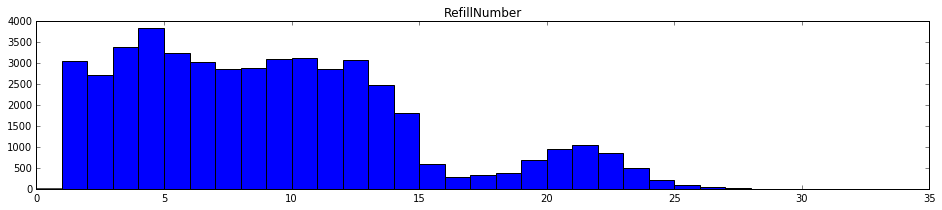

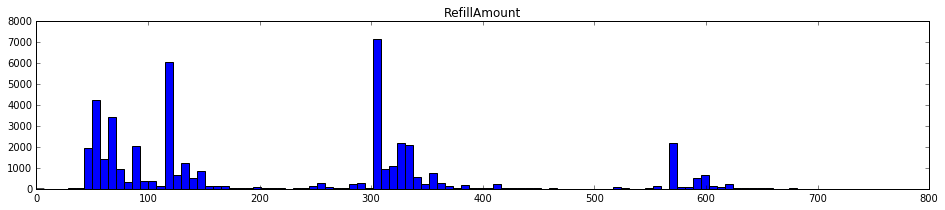

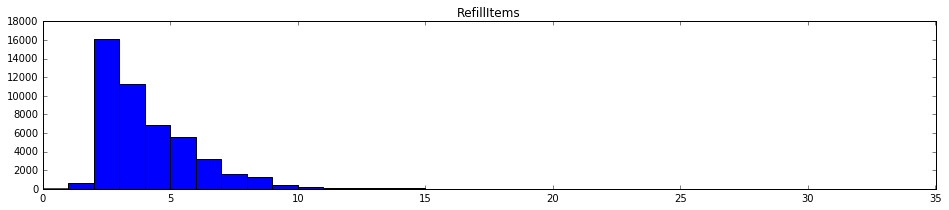

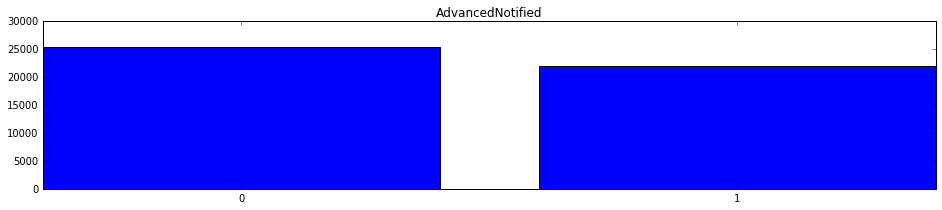

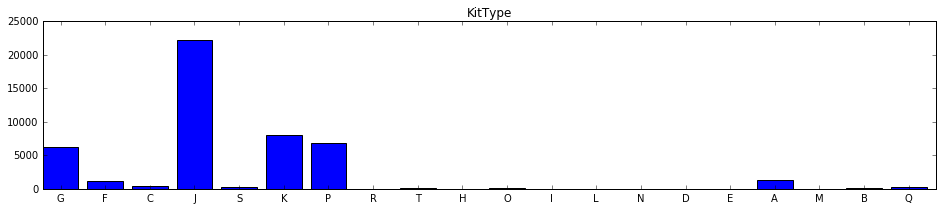

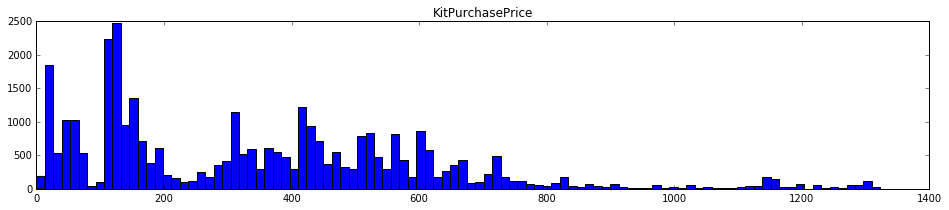

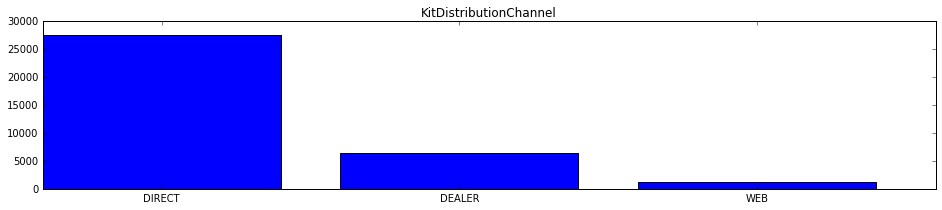

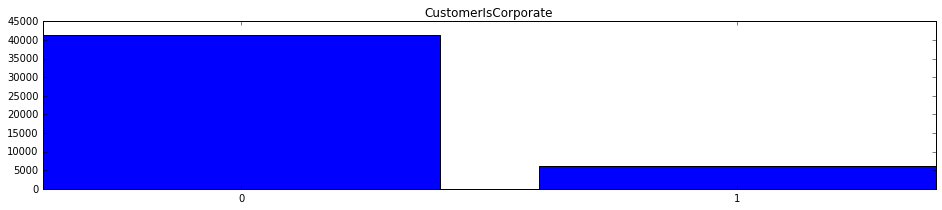

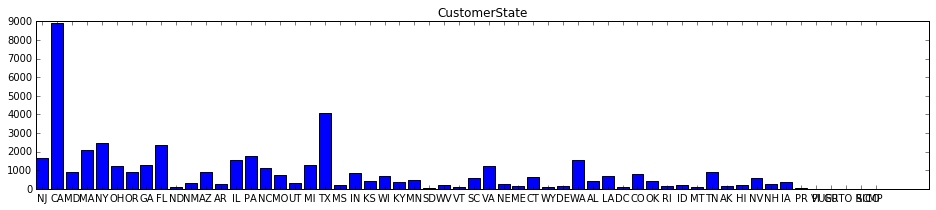

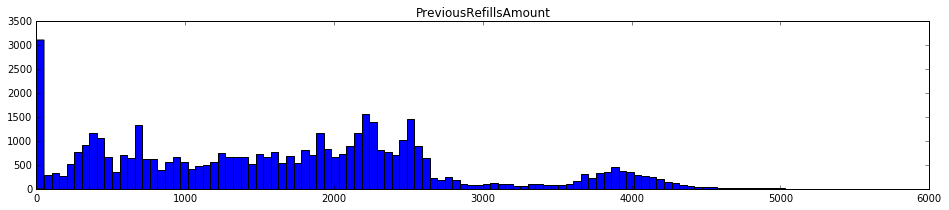

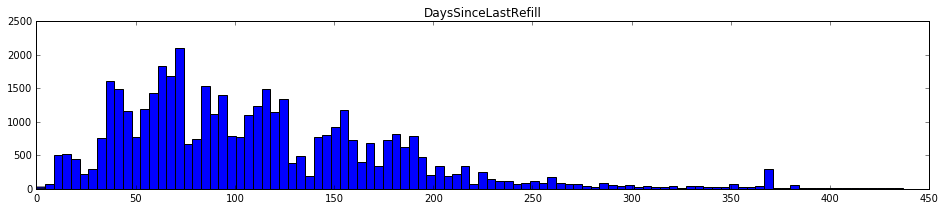

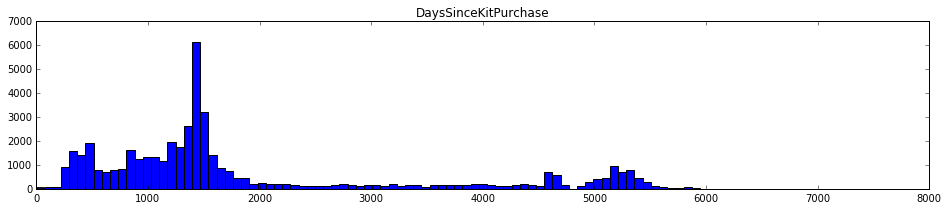

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
for col, col_data in X_raw.iteritems():
    plt.figure(figsize=(16,3))
    if col in category_columns:
        values = [x for x in col_data.unique() if x == x]
        index = np.arange(len(values))
        counts = list(col_data[col_data == value].count() for value in values)
        bar_width = 0.8
        
        plt.bar(index, counts, bar_width)
        plt.xticks(index + bar_width/2, values)
    else:
        bins = range(col_data.max() + 1) if len(col_data.unique()) < 100 else 100
        plot_data = [x for x in col_data.values if not np.isnan(x)]
        plt.hist(plot_data, bins=bins, range=[0, min(col_data.max(), col_data.mean() + 3*col_data.std())])
    plt.title(col)
    plt.show()

`RefillNumber` is fairly evenly distributed at the lower end, with between 6% and 8% of the samples belonging to each `RefillNumber` value up to 12, after which it drops off sharply. `PreviousRefillsAmount` shares a similar distribution, dropping off after around \$2,500, which indicates a fairly consistent refill price. This is confirmed by examining the distribution of `RefillAmount`, which is heavily concentrated around \$100, \$300, and \$550. Also very consistent is the number of items contained in the refill, with nearly all of the samples having a `RefillItems` value between 2 and 6.

The distributions of `RefillNumber`, `PreviousRefillsAmount`, and `DaysSinceKitPurchase` seem to indicate that there are two distinct kit groups. Most of the samples belong to kits sold in the past few years. However, there is also a smaller group of long-standing installs. The behavior of these two groups might differ significantly.

Other notes:
* `DaysSinceLastRefill` seems almost normally distributed around 60 days, though it is definitely skewed to the right.
* In contrast, `DaysSinceKitPurchase` is heavily concentrated around 1,500 days.
* Around half of the refills were preceded by a notification.
* Around 60% of the refills belong to kits that were sold directly to the customer.
* Almost half of the samples belong to `KitType` J, and nearly all of the samples belong to `KitType` G, J, K, or P.
* Over one-fifth of the samples belong to customers in California, with Texas coming in second place at around one-tenth. The other states are relatively evenly distributed.

### Algorithms and Techniques
Scalability is the name of the game, here. With nearly 48,000 samples on which to train, and more assuredly available in a production environment, the algorithm chosen must scale well in the number of samples. In addition, the algorithm must scale well in the number of features. We've identified 10 features to start with but that might, and probably will, grow quickly as the understanding of customer behavior improves. The number of features will likely never outgrow the number of samples, however.

The final model will be used to predict the result of upcoming refills on demand. A quick prediction time is therefore very important, and will it will only become more important as the customer base grows. Lazy learners would therefore not be suitable for this problem. On the other hand, training time is not a significant factor. As new data becomes available, the model can be retrained asynchronously and pushed to live when ready. Online learners would be ideal in this situation, as the true results of each refill are available after 45 days and the model could then be updated with the new information.

Based on the above, and by consulting the sklearn documentation on choosing an estimator, the following algorithms will be trained and tested:
* SGD Classifier
* Decision Trees (including random forest)

LinearSVC was considered at first, but stochastic gradient descent can perform the same optimization with better performance and the benefit of online learning.

### Benchmark
The business's assumption up to this point was that customers have not been properly educated of the refill process and were cancelling after receiving their first refill. Another assumption was that a few, high-priced items were responsible for a large proportion of the cancellations. These two assumptions together will define our benchmark, which will be as follows: if a refill is the kit's first, assume deactivation. If the average item price in the refill is more than $200, assume deactivation. Otherwise, assume no change. For simplicity, the benchmark will be established as a binary classifier.

## Methodology
### Data Preprocessing
The following tasks need to be performed:
1. Impute missing values
  * To increase the predictor's accuracy, samples will be grouped by class before imputing.
  * First refills have a `NaN` value for `DaysSinceLastRefill`, which would be replaced with the mean during imputation. It would be more appropriate to transform the feature to its reciprocal and give first refills a value of zero.
* One-hot encode categorical features

### Implementation
#### Imputing and One-hot Encoding

In [5]:
# Impute missing values by class
X_imputed = pd.DataFrame()
results = y_all.unique()
for result in results:
    X_class = X_raw[y_all == result]
    X_class_imputed = pd.DataFrame(index = X_class.index)
    for col, col_data in X_class.iteritems():
        # Impute categorical with mode, numerical with mean
        fill_value = col_data.mode()[0] if col_data.dtype == object else col_data.mean()
        X_class_imputed = X_class_imputed.join(col_data.fillna(fill_value))
    X_imputed = X_imputed.append(X_class_imputed, verify_integrity = True)
X_imputed.sort_index(inplace=True)

X_all = pd.DataFrame(index = X_imputed.index)
for col, col_data in X_imputed.iteritems():
    # Transform DaysSinceLastRefill to reciprocal, fill NULL with 0
    if col == 'DaysSinceLastRefill':
        col_data = X_raw[col].rtruediv(1).replace(np.inf, 0).fillna(0)
        col_data.name = 'RefillFrequency'
    # Split categorical features into multiple binary columns
    elif col_data.dtype == object and set(col_data.unique()) != set([0,1]):
        col_data = pd.get_dummies(col_data, prefix=col)
    X_all = X_all.join(col_data)

X_all.head()

,RefillNumber,RefillAmount,RefillItems,AdvancedNotified,KitType_A,KitType_B,KitType_C,KitType_D,KitType_E,KitType_F,...,CustomerState_VA,CustomerState_VI,CustomerState_VT,CustomerState_WA,CustomerState_WI,CustomerState_WV,CustomerState_WY,PreviousRefillsAmount,RefillFrequency,DaysSinceKitPurchase
0,19,129.40,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3689.04,0.006410,3145
1,19,129.40,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3689.04,0.006410,3167
2,1,91.28,7,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.00,0.000000,3185
3,2,115.45,2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,91.28,0.026316,3223
4,8,320.50,8,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1498.30,0.002695,5190


#### Performance Metric Definition

In [6]:
from sklearn.metrics import recall_score, precision_score, make_scorer

def scoring_function(y_true, y_pred):
    precision = precision_score(y_true, y_pred, labels=['Deactivated', 'Downgraded'], average='micro')
    if precision < 0.9:
        return 0
    return recall_score(y_true, y_pred, labels=['Deactivated', 'Downgraded'], average='micro')

scorer = make_scorer(scoring_function)
recall_scorer = make_scorer(recall_score, labels=['Deactivated', 'Downgraded'], average='micro')
precision_scorer = make_scorer(precision_score, labels=['Deactivated', 'Downgraded'], average='micro')

#### Benchmarking and Initial Algorithm Testing

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, cross_val_score

# Prepare candidate algorithms
random_state = 1993
results = []
classifiers = [
    DecisionTreeClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    SGDClassifier(random_state=random_state)
]
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=random_state)

# Establish benchmark
y_bench = []
for index, row in X_train.iterrows():
    if row['RefillNumber'] == 1:
        y_bench.append(1)
    elif row['RefillAmount']/row['RefillItems'] >= 200:
        y_bench.append(1)
    else:
        y_bench.append(0)
y_bench = pd.Series(y_bench)
y_true = 1 - pd.get_dummies(y_train)['No change']
results.append(['Benchmark', recall_score(y_true, y_bench), precision_score(y_true, y_bench)])

# Test candidate algorithms
for clf in classifiers:
    classifier = clf.__class__.__name__
    recall = cross_val_score(clf, X_train, y_train, scoring=recall_scorer, n_jobs=-1)
    precision = cross_val_score(clf, X_train, y_train, scoring=precision_scorer, n_jobs=-1)
    results.append([classifier, recall.mean(), precision.mean()])

results = pd.DataFrame(
    data = results,
    columns = [
        'classifier',
        'recall',
        'precision'
    ]
)

display(results)

,classifier,recall,precision
0,Benchmark,0.274942,0.086307
1,DecisionTreeClassifier,0.223924,0.187479
2,RandomForestClassifier,0.134582,0.469418
3,SGDClassifier,0.015099,0.037342


#### Parameter Tuning

In [8]:
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
parameters = [
    {
        'criterion': ('gini', 'entropy'),
        'max_features': ('sqrt', 'log2', None),
        'max_depth': (3, 4, 5, 6, 7, 8, 9, 10, None),
        'min_samples_split': (2, 5, 10, 25, 50, 75, 100, 150, 200, 250, 500, 1000)
    }
]
clf = GridSearchCV(DecisionTreeClassifier(random_state=random_state), parameters, scoring=scorer, n_jobs=-1)
clf.fit(X_train, y_train)
print "Best DecisionTreeClassifier score: {}".format(clf.best_score_)
print clf.best_params_

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/python2/lib/python2.7/site-packa

Best DecisionTreeClassifier score: 0.113688103654
{'max_features': None, 'min_samples_split': 2, 'criterion': 'entropy', 'max_depth': 4}


In [9]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters = [
    {
        'n_estimators': (2, 5, 10, 15, 20, 25, 50, 75, 100),
        'criterion': ('gini', 'entropy'),
        'max_features': ('sqrt', 'log2', None),
        'max_depth': (3, 4, 5, 6, 7, 8, 9, 10, None),
        'min_samples_split': (2, 5, 10, 25, 50, 75, 100, 150, 200, 250, 500, 1000)
    }
]
clf = GridSearchCV(RandomForestClassifier(random_state=random_state), parameters, scoring=scorer, n_jobs=-1)
clf.fit(X_train, y_train)
print "Best RandomForestClassifier score: {}".format(clf.best_score_)
print clf.best_params_

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/python2/lib/python2.7/site-packa

Best RandomForestClassifier score: 0.155463101231
{'max_features': None, 'min_samples_split': 10, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 50}


In [7]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier
parameters = [
    {
        'loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'),
        'penalty': ('none', 'l2', 'l1', 'elasticnet'),
        'alpha': (0.0001, 0.001, 0.01),
        'l1_ratio': (0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0),
        'fit_intercept': (True, False),
        'n_iter': (1, 5, 10, 50, 100),
        'warm_start': (True, False)
    }
]
clf = GridSearchCV(SGDClassifier(random_state=random_state), parameters, scoring=scorer, n_jobs=-1)
clf.fit(X_train, y_train)
print "Best SGDClassifier score: {}".format(clf.best_score_)
print clf.best_params_

Best SGDClassifier score: 0.00115752926863
{'warm_start': False, 'n_iter': 100, 'loss': 'log', 'l1_ratio': 0.125, 'fit_intercept': True, 'penalty': 'elasticnet', 'alpha': 0.01}


## Results
### Model Evaluation and Validation
Based on the tuned performance of the models above, `RandomForestClassifier` seems to be a clear winner. To confirm, its performance on the testing set will now be measured.

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier   
clf = RandomForestClassifier(
    max_features = None,
    min_samples_split = 10,
    criterion = 'entropy',
    max_depth = None,
    n_estimators = 50,
    random_state=random_state
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
recall = recall_score(y_test, y_pred, labels=['Deactivated', 'Downgraded'], average='micro')
precision = precision_score(y_test, y_pred, labels=['Deactivated', 'Downgraded'], average='micro')
print "Test Recall: {}".format(recall)
print "Test Precision: {}".format(precision)

Test Recall: 0.162790697674
Test Precision: 0.945945945946


This model generalizes well to unseen data. Its performance on the testing set is very similar to its performance on the training set. Moreover, its performance is reasonably strong. Its precision is above the required threshold of 0.9, and its recall of 0.163 is more than enough to consider using the model in a test intervention system. Moreover, it is much more accurate than the benchmark. The simple model formed by the assumptions the business had been making only had a recall of 0.274942 and precision of 0.086307. In other words, it predicted more of the cancellations, but it also predicted cancellation far more often than was true.

The benchmark model would be useless in an intervention system as the value recovered from saving potential quits would quickly be burnt pursuing the wrong targets. In contrast, the random forest classifier trained above rarely predicts a cancellation that is unwarranted. However, its clear that some aspect of the problem is still not being captured by the data. I believe that identifying additional relevant features - for example, by conducting exit interviews with customers who cancelled unpredictedly - will improve the recall. In the meantime, I believe that this model can still save a significant number of customers.

## Conclusion
### Free-Form Visualization

A predictor is useful, but far more useful is intuitive understanding of the problem at hand. It's lucky, then, that the two highest-performing models (the decision tree and, by extension, the random forest) can be represented visually. The behavior of the important features will be explored below.

In [11]:
relevance = pd.DataFrame([clf.feature_importances_], index=['importance'], columns = X_train.columns)
relevance[relevance > 0.01].dropna(axis=1).transpose().sort_values('importance', ascending = False)

,importance
DaysSinceKitPurchase,0.229165
KitPurchasePrice,0.201741
PreviousRefillsAmount,0.100738
RefillFrequency,0.098787
RefillAmount,0.059242
RefillNumber,0.026945
CustomerState_CA,0.022067
RefillItems,0.020982
CustomerIsCorporate,0.014289
CustomerState_NY,0.011180


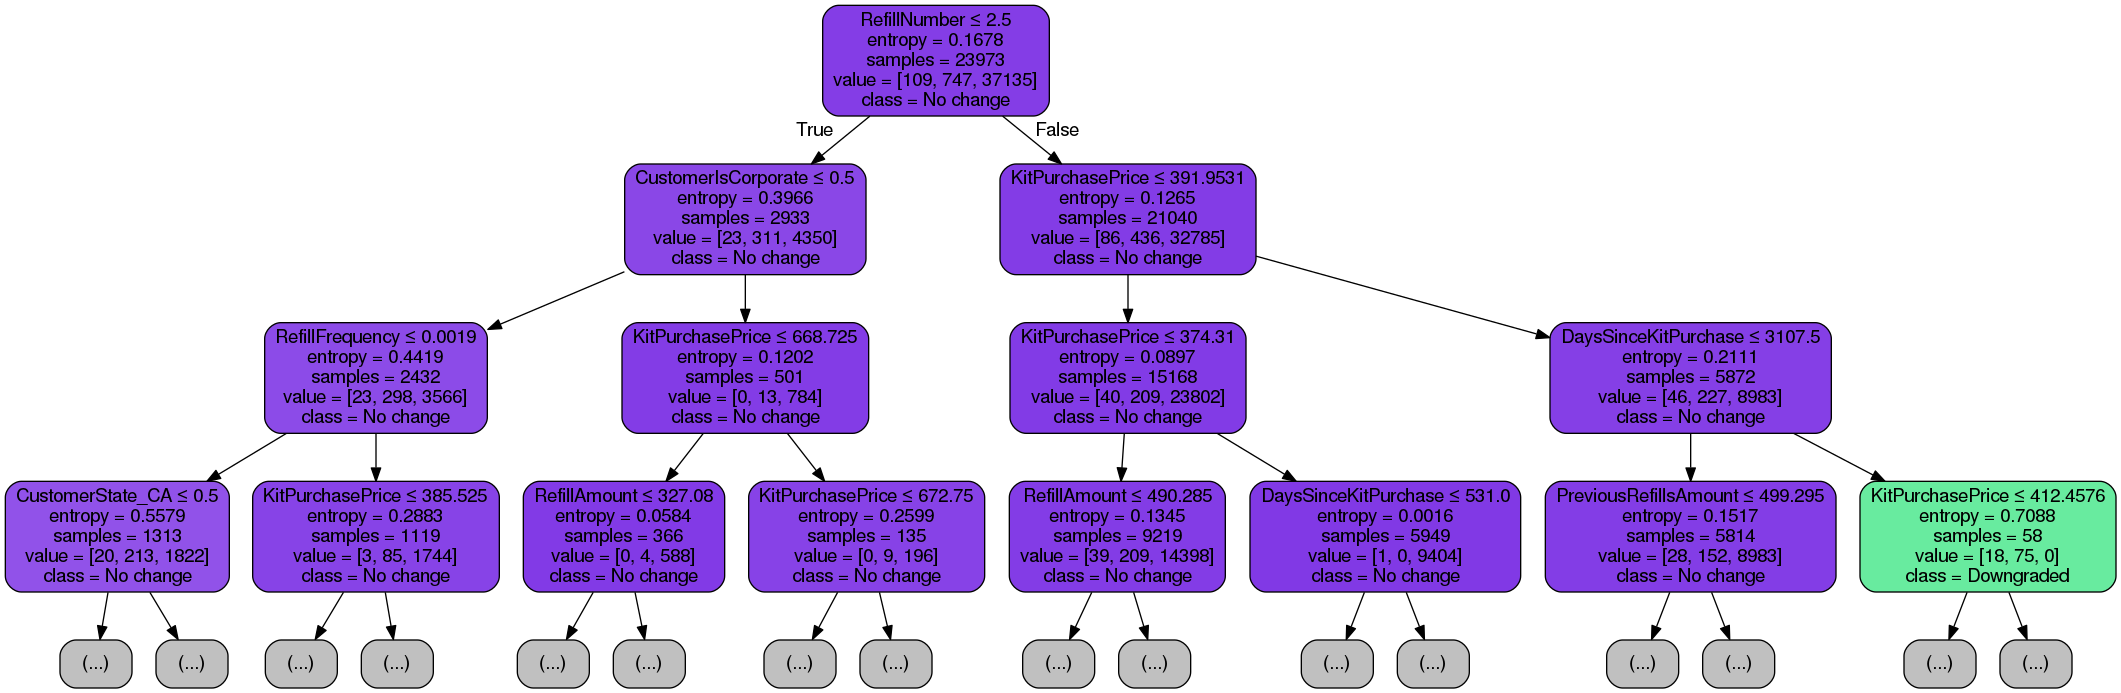

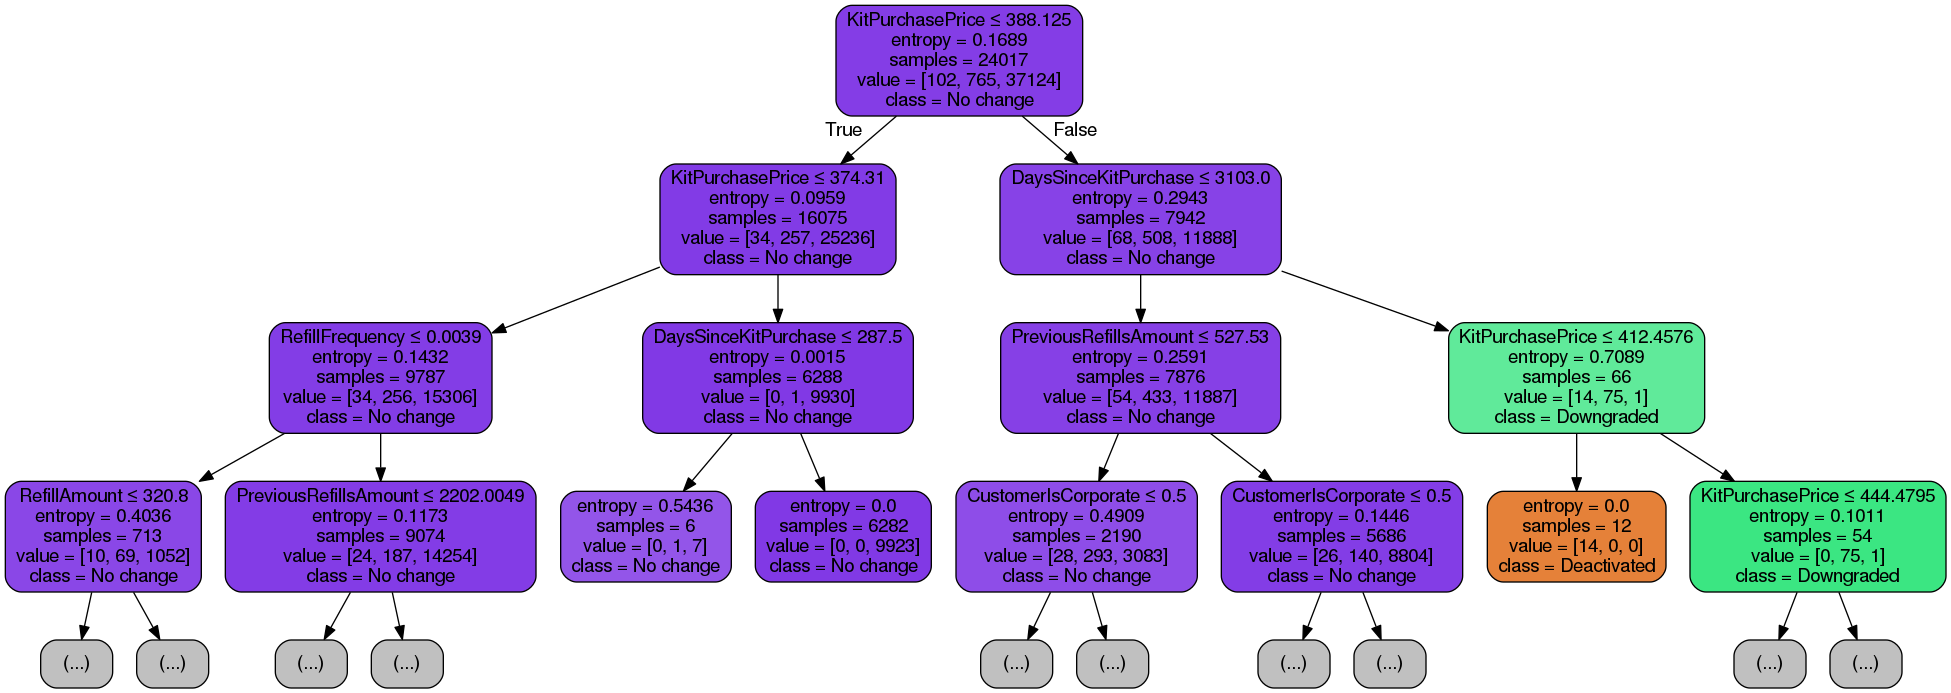

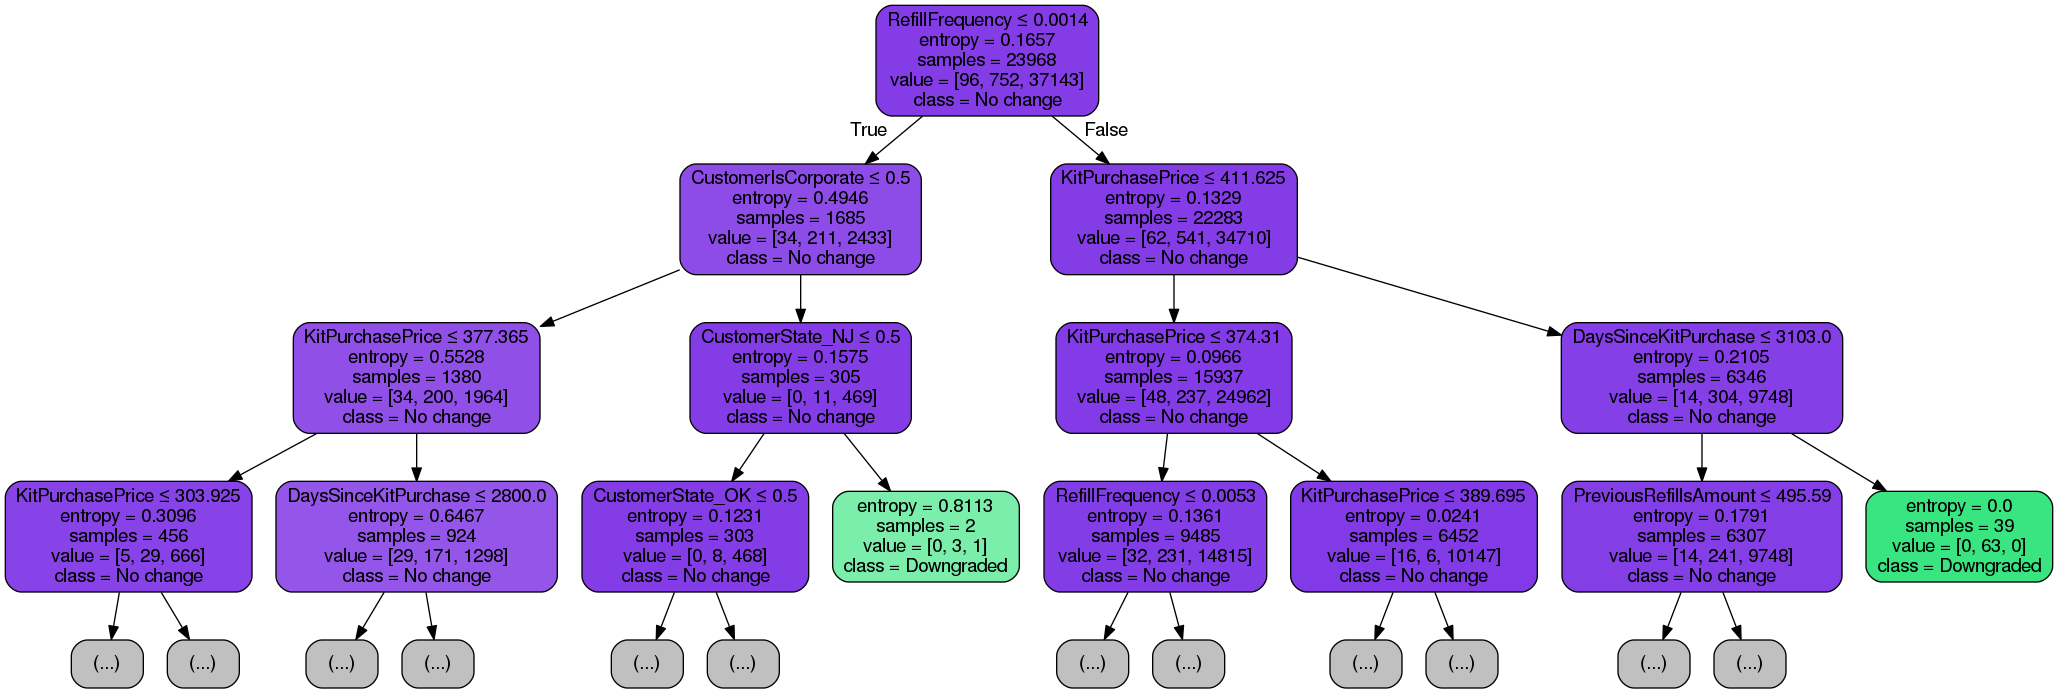

In [12]:
from sklearn.externals.six import StringIO 
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydot import graph_from_dot_data

for dt in clf.estimators_[:3]:
    dot_data = StringIO()  
    export_graphviz(
        dt,
        out_file=dot_data,
        feature_names=X_all.columns,
        class_names=clf.classes_,
        max_depth=3,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graph_from_dot_data(dot_data.getvalue())
    display(Image(graph.create_png()))

It seems that what the predictor has uncovered is a pattern of high cancellation among low-priced kits that have been active for a long time. After some consideration, this makes sense. Even highly-satisfied customers will eventually cancel, for example due to a change in circumstance such as retiring. Such customers might neglect to cancel their subscription. Then, after receiving a refill they might not have been expecting, they would have to go through the process of returning the items and cancelling the subscription, all of which involves lost time and money. This predictor would be able to identify such customers and prevent that waste with some effort beforehand.

### Reflection
Far and away, the main challenge in this project was in preparing the data. Many new views were prepared involving several tables. For example, the necessary table relationships to uncover purchase information for kits had to be discovered, and these were still not enough to overcome data integrity issues for older kits. These data integrity issues continued to complicate the project beyond the data preparation phase. Missing values for certain features needed to be imputed in the preprocessing phase. On the other hand, there is an abundance of available data. Modeling such an unbalanced problem would be highly innacurate were there not tens of thousands of available samples. Moreover, I have already begun the process of improving data storage protocols, including ensuring that certain historical data is stored to make reporting easier (or, in some cases, simply possible) in the future. This will enable further iterative improvement of the predictor.

Two issues mentioned above impacted the project in both positive and negative ways: the large amount of data and the unbalanced classes. A large dataset is a luxury, but it also led to comparatively long training times. Performing a parameter grid search took upwards of a few hours for the more complicated algorithms, even on a powerful dedicated machine. The unbalanced classes made choosing a performance metric a novel and engaging challenge. However, I suspect they also raise the standard on the input data for producing a high-quality model.

At this point, though, I am quite pleased with the result of this project. For several reasons, not least among them being my own novicehood, I was not expecting the final model to have as high a precision as it does. To be sure, I would prefer that the precision had also exceeded my expectation. All that said, I feel quite comfortable testing this model in a production-like environment.

### Improvement
As I've mentioned above, I believe that adding additional relevant features will improve the recall. In particular, the business believes that certain key, high-priced items are possibly triggering cancellations. I've considered adding a boolean "is_included" feature for each of those items. Also, the data has a focus on kits rather than customers. For example, if a customer were to cancel a kit and purchase a new one, this is not explicitly reflected in the data at the moment. Further, features like customer lifetime and balance due at the time of refill might expose critical patterns in behavior.

Exploring the customer angle further, I've also had the idea to perform a customer segmentation analysis. Such an analysis could provide valuable insight into customer behavior in addition to providing a few relevant features for training the predictor. The first of these would obviously be the segment number of the customer to which the kit belongs. Clustering would also allow me to establish an average customer lifetime value (CLV) for each segment. A cost function for the predictor could then be defined using this CLV in the following way: if the predictor fails to catch a cancellation, it will incur a penalty of the deficit between that customer's current lifetime value and the average CLV for that customer's segment. In this way, the process of fitting the model to the data will be directly optimizing the potential value that could be recovered by using the predictor.

Finally, I will admit to being disappointed that the `SGDClassifier` algorithm did not perform very well. An online learner would be a big bonus for iteratively improving the predictor. One such learner I left out of this project, mostly due to lacking the requisite experience, is a neural net. Though it carries with it the disadvantage of being black boxes, it is an online learner with a strong reputation in the industry today.